# I-JEPA

## Get embeddings
The I-JEPA model is not inferencible the way Meta released it.  I had to reverse engineer it to be able to get embedings out of it.  This code is going to download my Git repository with I-JEPA and save image latents

In [1]:
# Download Git repository 

!gh repo clone git@github.com:ianjwhitehouse/inference-ijepa.git
!wget -P inference-ijepa/logs/vith16.448-bs.2048-ep.300 https://dl.fbaipublicfiles.com/ijepa/IN1K-vit.h.16-448px-300e.pth.tar

fatal: destination path 'inference-ijepa' already exists and is not an empty directory.
failed to run git: exit status 128
--2024-05-07 01:28:30--  https://dl.fbaipublicfiles.com/ijepa/IN1K-vit.h.16-448px-300e.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.79, 18.165.83.91, 18.165.83.35, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10367908521 (9.7G) [application/x-tar]
Saving to: ‘inference-ijepa/logs/vith16.448-bs.2048-ep.300/IN1K-vit.h.16-448px-300e.pth.tar.1’

                IN1  70%[=============>      ]   6.80G  87.8MB/s    eta 31s    ^C


In [2]:
# Create JEPA config files
import os

cwd = os.getcwd()
img_path = os.path.join(cwd, "images/training_imgs")
logging_path = os.path.join(cwd, "inference-ijepa/logs/vith16.448-bs.2048-ep.300/")

config_file = """data:
  batch_size: 16
  color_jitter_strength: 0.0
  crop_scale:
  - 0.3
  - 1.0
  crop_size: 448
  image_folder: .
  num_workers: 10
  pin_mem: true
  root_path: %s
  use_color_distortion: false
  use_gaussian_blur: false
  use_horizontal_flip: false
logging:
  folder: %s
  write_tag: jepa
mask:
  allow_overlap: false
  aspect_ratio:
  - 0.75
  - 1.5
  enc_mask_scale:
  - 0.85
  - 1.0
  min_keep: 10
  num_enc_masks: 1
  num_pred_masks: 4
  patch_size: 16
  pred_mask_scale:
  - 0.15
  - 0.2
meta:
  copy_data: false
  load_checkpoint: true
  model_name: vit_huge
  pred_depth: 12
  pred_emb_dim: 384
  read_checkpoint: IN1K-vit.h.16-448px-300e.pth.tar
  use_bfloat16: true
optimization:
  ema:
  - 0.996
  - 1.0
  epochs: 300
  final_lr: 1.0e-06
  final_weight_decay: 0.4
  ipe_scale: 1.0
  lr: 0.001
  start_lr: 0.0002
  warmup: 40
  weight_decay: 0.04"""

with open("jepa_train_config.yaml", "w") as f:
    f.write(config_file % (img_path, logging_path))

img_path = os.path.join(cwd, "images/example_imgs")
with open("jepa_test_config.yaml", "w") as f:
    f.write(config_file % (img_path, logging_path))

In [3]:
# Run I-JEPA

!python inference-ijepa/main-inference.py --fname=jepa_train_config.yaml
!mv images/training_imgs/jepa_encodings.pkl jepa_encodings_train.pkl
!python inference-ijepa/main-inference.py --fname=jepa_test_config.yaml
!mv images/example_imgs/jepa_encodings.pkl jepa_encodings_test.pkl

Traceback (most recent call last):
  File "/home/ian/outfit-recomender/inference-ijepa/main-inference.py", line 15, in <module>
    from src.utils.distributed import init_distributed
  File "/home/ian/outfit-recomender/inference-ijepa/src/utils/distributed.py", line 10, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
mv: cannot stat 'images/training_imgs/jepa_encodings.pkl': No such file or directory
Traceback (most recent call last):
  File "/home/ian/outfit-recomender/inference-ijepa/main-inference.py", line 15, in <module>
    from src.utils.distributed import init_distributed
  File "/home/ian/outfit-recomender/inference-ijepa/src/utils/distributed.py", line 10, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
mv: cannot stat 'images/example_imgs/jepa_encodings.pkl': No such file or directory


## Visualize model embeddings

In [4]:
# Load images
import numpy as np
from PIL import Image
import os

# Training
image_folder = "images/training_imgs"

# Log all sets of images so they are in the same order
full_body_images = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith("fb.png")]
clothing_images = [file[:-6] + "c.png" for file in full_body_images]
full_body_raw = [file[:-6] + "fb-unedited.png" for file in full_body_images]

# Break into categories
clothing_labels = [file.split("/")[-1].split("-")[0].split("_") for file in clothing_images]
clothing_images = [Image.open(file) for file in clothing_images]
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

full_body_labels = [file.split("/")[-1].split("-")[0].split("_") for file in full_body_images]
full_body_images = [Image.open(file) for file in full_body_images]
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]

full_body_raw = [Image.open(file) for file in full_body_raw]

# Test
image_folder = "images/example_imgs"

# Break into categories
test_clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder)]

In [5]:
# Load images
from pickle import load
import os
from PIL import Image
import numpy as np

embeds = load(open("jepa_encodings_train.pkl", "rb"))
image_folder = "images/training_imgs"

# Log all sets of images so they are in the same order
full_body_embed = [k for k in embeds.keys() if k.endswith("fb.png")]
clothing_embed = [file[:-6] + "c.png" for file in full_body_embed]
full_body_raw = [os.path.join(image_folder, file[:-6] + "fb-unedited.png") for file in full_body_embed]

# Break into categories
clothing_images = [Image.open(os.path.join(image_folder, file)) for file in clothing_embed]
clothing_labels = [file.split("-")[0].split("_") for file in clothing_embed]
clothing_embed = np.array([embeds[file] for file in clothing_embed])
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

full_body_labels = [file.split("-")[0].split("_") for file in full_body_embed]
full_body_embed = np.array([embeds[file] for file in full_body_embed])
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]

full_body_raw = [Image.open(file) for file in full_body_raw]

# Test
image_folder = "images/example_imgs"
embeds = load(open("jepa_encodings_test.pkl", "rb"))

# Break into categories
test_clothing_embed = [k for k in embeds.keys()]
test_clothing_images = [Image.open(os.path.join(image_folder, file)) for file in test_clothing_embed]
test_clothing_embed = np.array([embeds[file] for file in test_clothing_embed])

In [6]:
# Make TSNE and PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

clothing_pca = PCA(n_components=2).fit(clothing_embed)
print(clothing_pca.explained_variance_ratio_, sum(clothing_pca.explained_variance_ratio_))
clothing_pca = clothing_pca.transform(clothing_embed)
clothing_tsne = TSNE().fit_transform(clothing_embed)

full_body_pca = PCA(n_components=2).fit(full_body_embed)
print(full_body_pca.explained_variance_ratio_, sum(full_body_pca.explained_variance_ratio_))
full_body_pca = full_body_pca.transform(full_body_embed)
full_body_tsne = TSNE().fit_transform(full_body_embed)

[0.26712825 0.12518382] 0.39231207101874865
[0.1800156  0.12068996] 0.30070556024842376


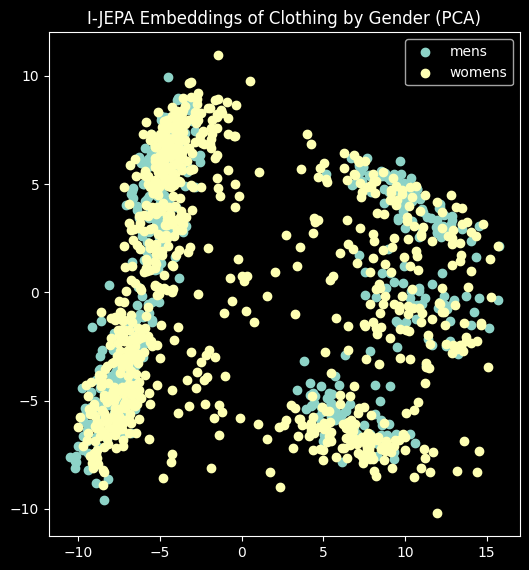

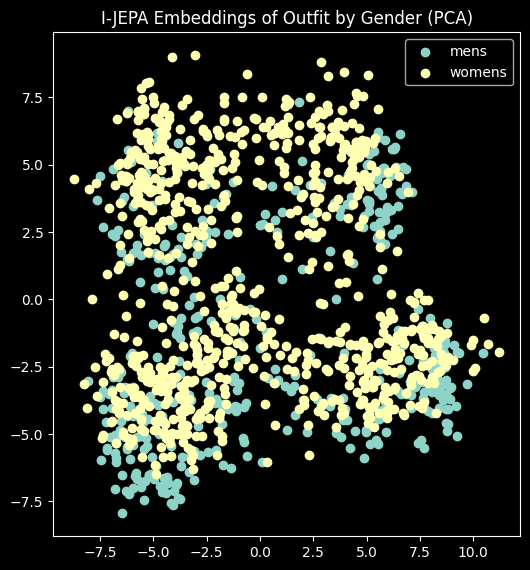

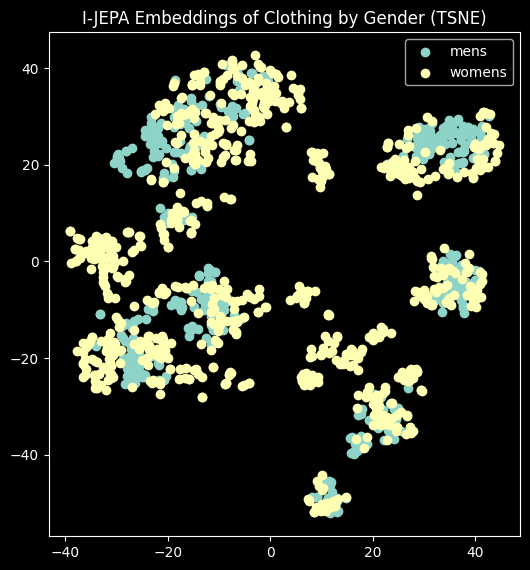

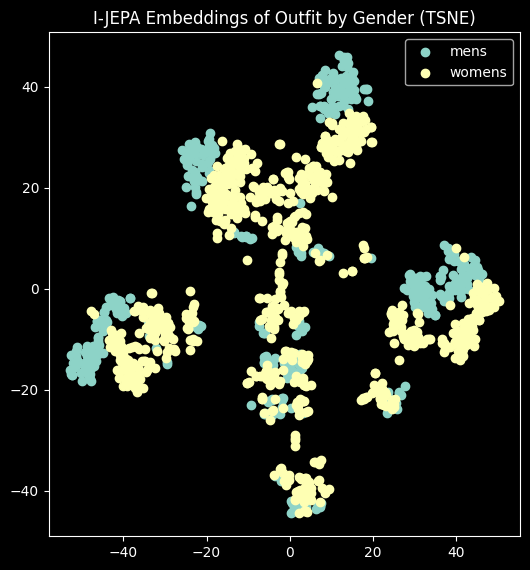

In [7]:
# Plot gendered items
import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("I-JEPA Embeddings of Clothing by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("I-JEPA Embeddings of Outfit by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("I-JEPA Embeddings of Clothing by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("I-JEPA Embeddings of Outfit by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

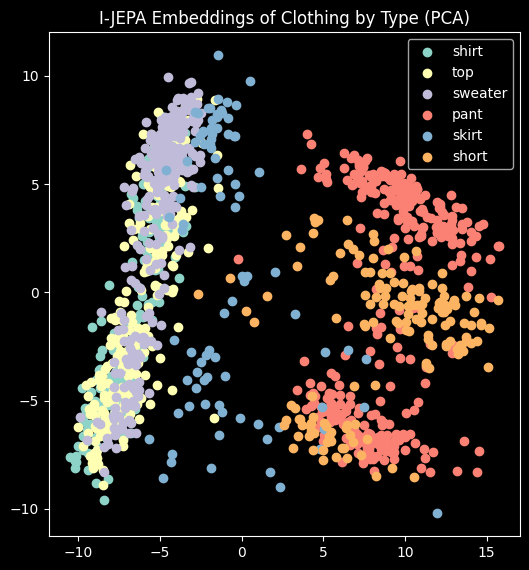

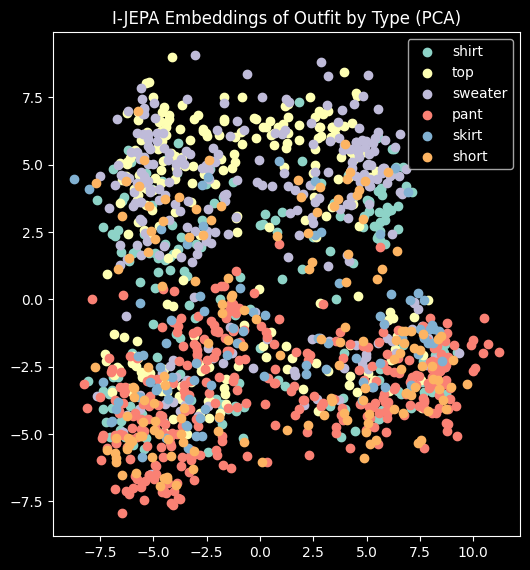

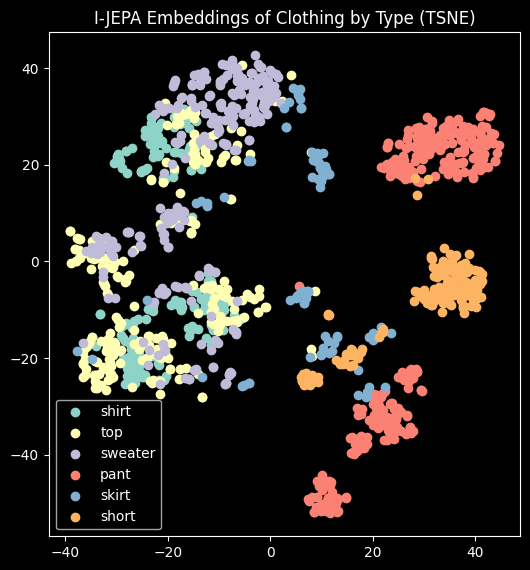

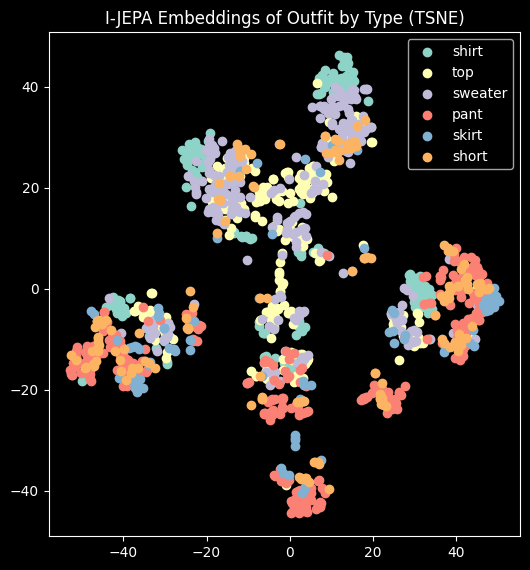

In [8]:
# Plot types of items

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("I-JEPA Embeddings of Clothing by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("I-JEPA Embeddings of Outfit by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("I-JEPA Embeddings of Clothing by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.4, 5.8])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("I-JEPA Embeddings of Outfit by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

## Testing embeddings using KNN

In [9]:
from sklearn.model_selection import train_test_split

y_map = {"shirt": 0, "top": 0, "sweater": 1, "pant": 2, "skirt": 3, "short": 4}
y = np.array([y_map[label[2]] for label in clothing_labels])
X_train, X_test, y_train, y_test = train_test_split(clothing_embed, y, test_size=0.25)

In [10]:
# Run KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

matrix = confusion_matrix(y_test, knn.predict(X_test))
acc_per_class = matrix.diagonal()/matrix.sum(axis=1)

print(acc_per_class)

[0.92436975 0.84615385 0.98717949 0.6        0.92682927]


## Plot demo outfits

In [11]:
# Refit KNN on all training

knn.fit(clothing_embed, y)

KNeighborsClassifier()

[2]
[[ 196  822   39 1179  109]]
[0]
[[107 868 556  33 996]]
[0]
[[725 262 107  33 682]]
[0]
[[107 868 996 725 239]]
[0]
[[703 630   7 576 193]]


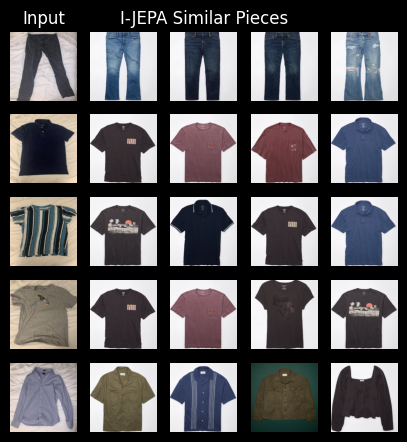

In [14]:
# Generate similar clothes
_, axs = plt.subplots(5, 5, figsize=(5,5.2))
axs[0, 0].set_title("Input")
axs[0, 2].set_title("I-JEPA Similar Pieces")

for i, test_emb in enumerate(np.delete(test_clothing_embed, 1, axis=0)):
    print(knn.predict(np.reshape(test_emb, (1, -1))))
    axs[i, 0].axis("off")
    axs[i, 0].imshow(np.delete(test_clothing_images, 1, axis=0)[i], aspect="auto")

    _, inds = knn.kneighbors(np.reshape(test_emb, (1, -1)))
    print(inds)
    for j, ind in enumerate(inds[0][:4]):
        axs[i, j + 1].axis("off")
        axs[i, j + 1].imshow(clothing_images[ind], aspect="auto")

plt.show()

[2]
[[ 196  822   39 1179  109]]
[0]
[[107 868 556  33 996]]
[0]
[[725 262 107  33 682]]
[0]
[[107 868 996 725 239]]
[0]
[[703 630   7 576 193]]


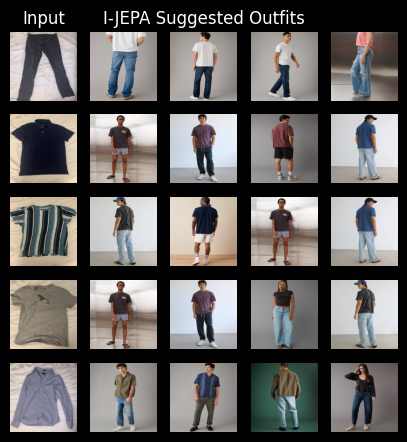

In [15]:
# Generate suggested outfits

_, axs = plt.subplots(5, 5, figsize=(5,5.2))
axs[0, 0].set_title("Input")
axs[0, 2].set_title("I-JEPA Suggested Outfits")

for i, test_emb in enumerate(np.delete(test_clothing_embed, 1, axis=0)):
    print(knn.predict(np.reshape(test_emb, (1, -1))))
    axs[i, 0].axis("off")
    axs[i, 0].imshow(np.delete(test_clothing_images, 1, axis=0)[i], aspect="auto")

    _, inds = knn.kneighbors(np.reshape(test_emb, (1, -1)))
    print(inds)
    for j, ind in enumerate(inds[0][:4]):
        axs[i, j + 1].axis("off")
        axs[i, j + 1].imshow(full_body_raw[ind], aspect="auto")

plt.show()